# Brain Tumor Detection: Simple CNN implementation using tensorflow

**Objectives**
* Implement a simple CNN for classification
* Evaluate classification metrics
* Evaluate hyperparameters tuning
* Achieve good model performance

**Importing libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import os
import mlflow

In [2]:
print(tf.__version__)

2.11.0


### Data Preprocessing

In [2]:
no_tumor = os.listdir("brain_tumor_dataset/no")
yes_tumor = os.listdir("brain_tumor_dataset/yes")

for count, value in enumerate(no_tumor):
    no_tumor[count] = "brain_tumor_dataset/no/" + str(value)

for count, value in enumerate(yes_tumor):    
    yes_tumor[count] = "brain_tumor_dataset/yes/" + str(value)


print(len(no_tumor), len(yes_tumor))

98 155


In [3]:
no_df = pd.DataFrame({"Image_path": no_tumor,
                      "label": np.zeros(len(no_tumor), dtype=int)})
no_df.head()

,Image_path,label
0,brain_tumor_dataset/no/1 no.jpeg,0
1,brain_tumor_dataset/no/10 no.jpg,0
2,brain_tumor_dataset/no/11 no.jpg,0
3,brain_tumor_dataset/no/12 no.jpg,0
4,brain_tumor_dataset/no/13 no.jpg,0


In [4]:
yes_df = pd.DataFrame({"Image_path": yes_tumor,
                      "label": np.ones(len(yes_tumor), dtype=int)})
yes_df.head()

,Image_path,label
0,brain_tumor_dataset/yes/Y1.jpg,1
1,brain_tumor_dataset/yes/Y10.jpg,1
2,brain_tumor_dataset/yes/Y100.JPG,1
3,brain_tumor_dataset/yes/Y101.jpg,1
4,brain_tumor_dataset/yes/Y102.jpg,1


In [5]:
data = pd.concat([no_df, yes_df]).sample(frac = 1, random_state=0)
data

,Image_path,label
60,brain_tumor_dataset/yes/Y193.JPG,1
83,brain_tumor_dataset/no/no 98.jpg,0
72,brain_tumor_dataset/yes/Y245.jpg,1
3,brain_tumor_dataset/yes/Y101.jpg,1
52,brain_tumor_dataset/yes/Y183.jpg,1
...,...,...
67,brain_tumor_dataset/no/no 3.jpg,0
94,brain_tumor_dataset/yes/Y31.jpg,1
19,brain_tumor_dataset/yes/Y117.JPG,1
47,brain_tumor_dataset/no/8 no.jpg,0


### Data Split

In [6]:
# Process for splitting the data
np.random.seed(10)
rnd = np.random.rand(len(data))
train = data[ rnd < 0.8  ]
test = data[ (rnd >= 0.8)]
print(len(data), len(train), len(test))

253 208 45


In [7]:
train.to_csv('train.csv', header=False, index=False)
test.to_csv('test.csv', header=False, index=False)

In [3]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

def read_and_decode(filename, reshape_dims):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, reshape_dims)

def decode_csv(csv_row):
    record_defaults = ["filepaths", "labels"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    return img, label_string

In [4]:
def plot_images(filename):
    matplotlib.rcParams.update({'font.size': 14})
    f, ax = plt.subplots(3, 5, figsize=(35,15))
    dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
    for idx, (img, label) in enumerate(dataset.take(15)):
        ax[idx//5, idx%5].imshow((img.numpy()));
        ax[idx//5, idx%5].axis('off')

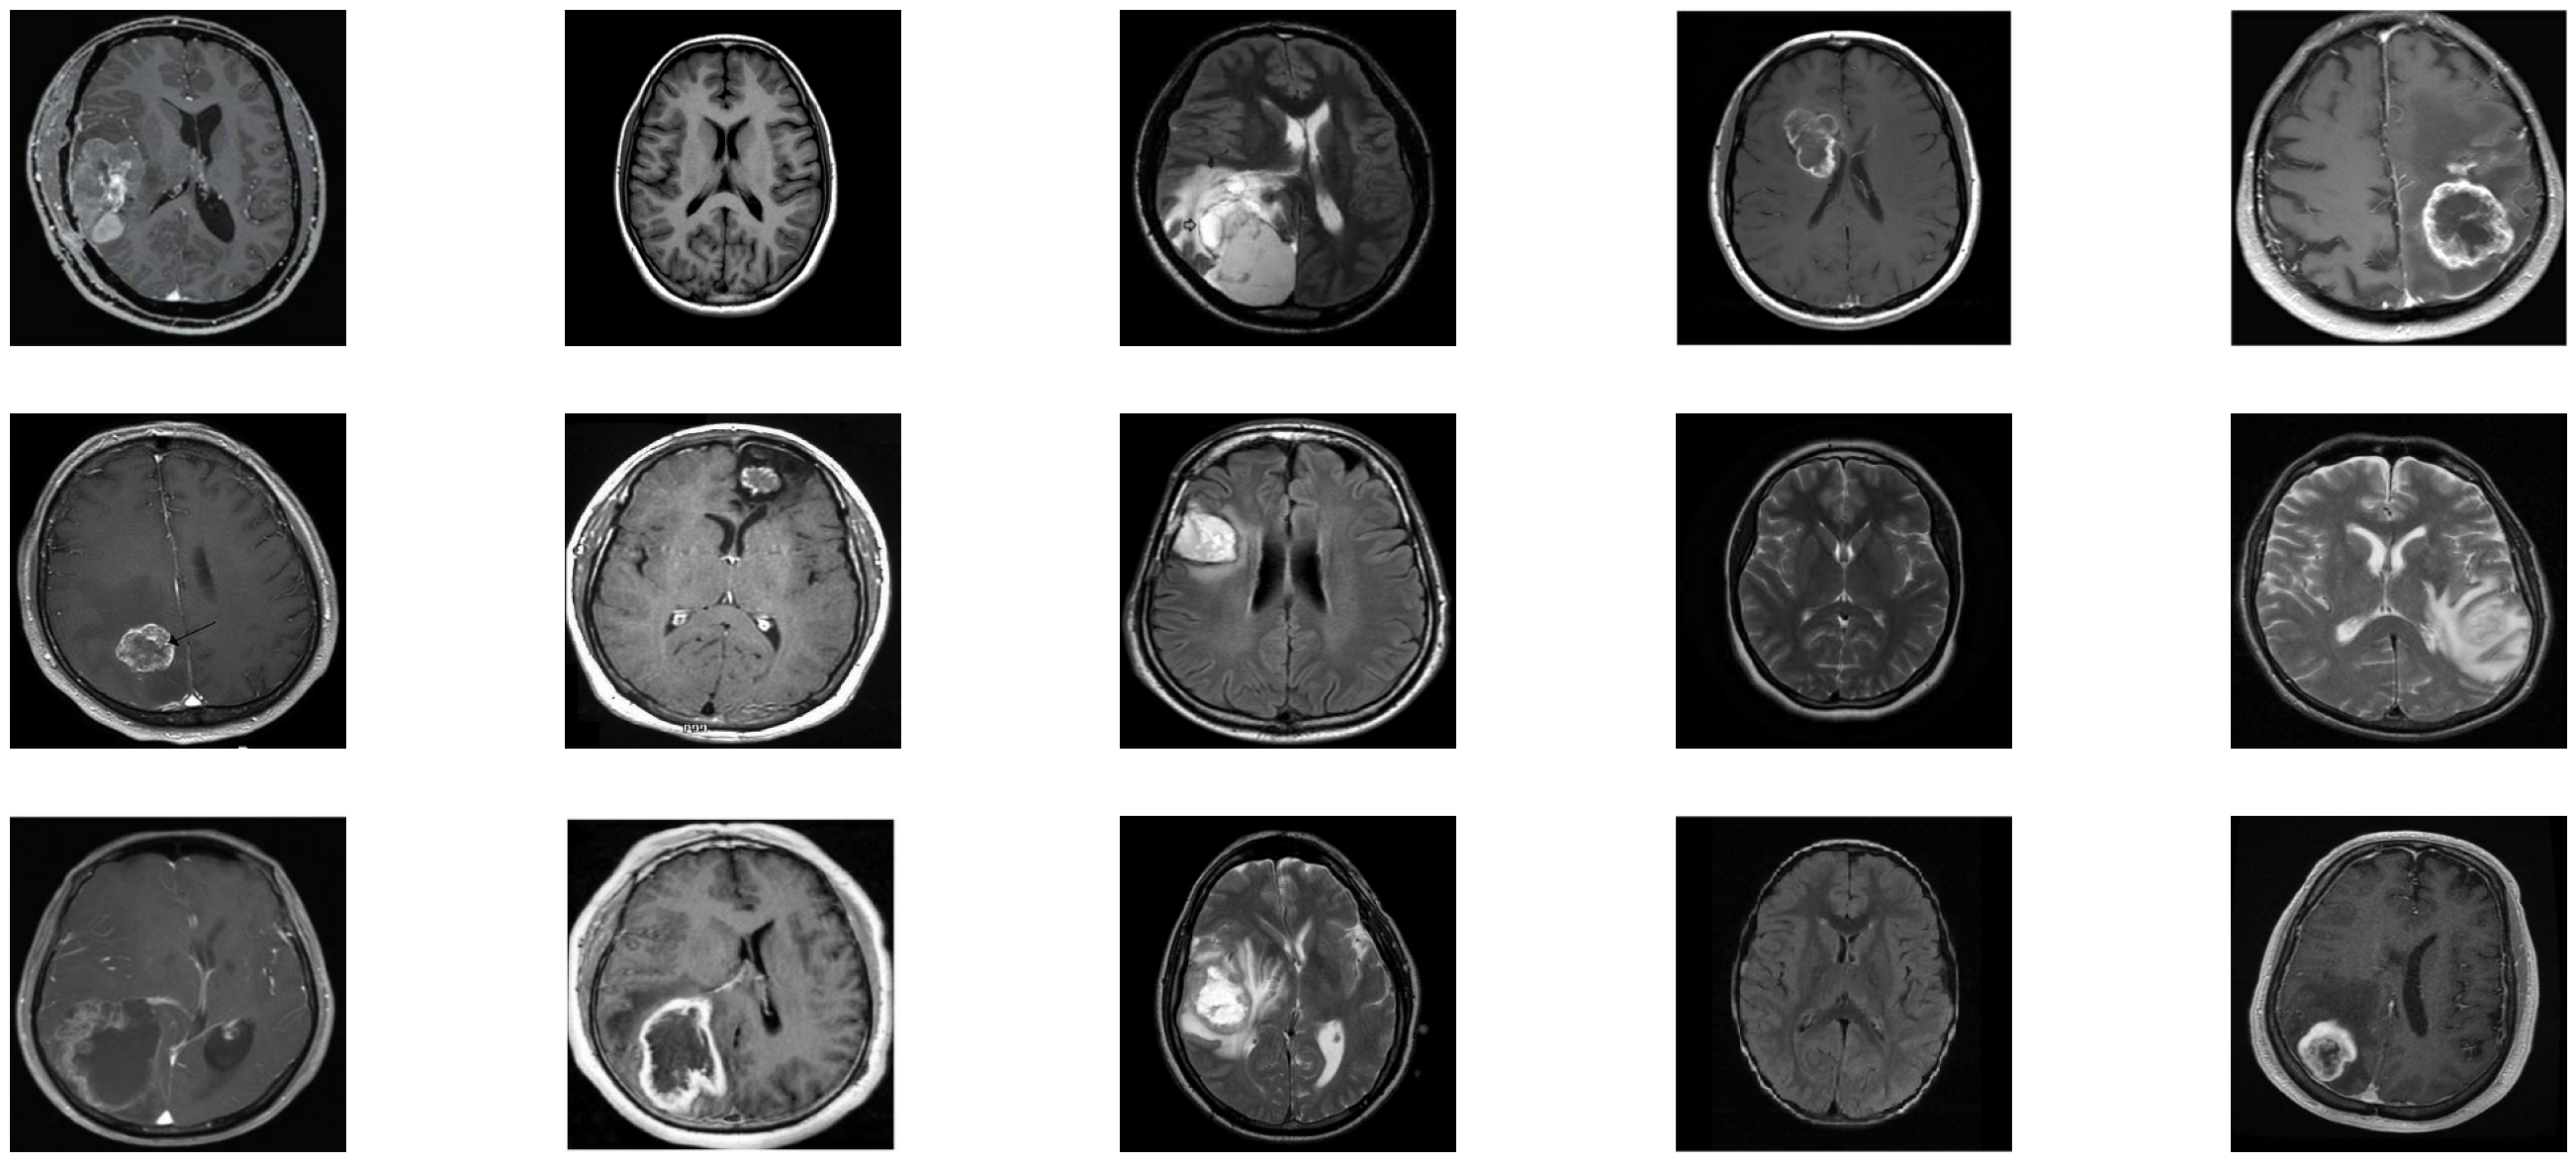

In [5]:
plot_images("train.csv")

In [6]:
# plotting utilities
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 4))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric]);
        ax[idx].legend([metric, 'val_' + metric])

### Generating Training and Testing data

In [7]:
def _decode_csv(csv_row):
    record_defaults = ["path", "class"]
    try:
        filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
        img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
        label = tf.argmax(tf.math.equal(["0","1"], label_string))
    except:
        print('File corrupted')
    return img, label

train_dataset = (tf.data.TextLineDataset('train.csv').map(_decode_csv)).batch(32)
test_dataset = (tf.data.TextLineDataset('test.csv').map(_decode_csv)).batch(32)

In [8]:
train_dataset, test_dataset

(<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Defining Custom Metric (pF1)

In [9]:
# custom metrics
class pFBeta(tf.keras.metrics.Metric):
    def __init__(self, beta=1, name='pF1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.beta = beta
        self.epsilon = 1e-10
        self.pos = self.add_weight(name='pos', initializer='zeros')
        self.ctp = self.add_weight(name='ctp', initializer='zeros')
        self.cfp = self.add_weight(name='cfp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 0, 1)
        pos = tf.cast(tf.reduce_sum(y_true), tf.float32)
        ctp = tf.cast(tf.reduce_sum(y_pred[y_true == 1]), tf.float32)
        cfp = tf.cast(tf.reduce_sum(y_pred[y_true == 0]), tf.float32)
        self.pos.assign_add(pos)
        self.ctp.assign_add(ctp)
        self.cfp.assign_add(cfp)

    def result(self):
        beta2 = self.beta * self.beta
        prec = self.ctp / (self.ctp + self.cfp + self.epsilon)
        reca = self.ctp / (self.pos + self.epsilon)
        return (1 + beta2) * prec * reca / (beta2 * prec + reca)

    def reset_state(self):
        self.pos.assign(0.)
        self.ctp.assign(0.)
        self.cfp.assign(0.)

### Build the Model

In [10]:
def build_model(num_classes=1):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(64, 7, activation='relu', padding='same',
                            input_shape= (256,256,3)),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
      tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
      tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(num_classes, activation='sigmoid')])
    return model

In [11]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 256)       2

### Creating a model checkpoint

In [12]:
checkpoint_filepath = 'models/Tumor_dtc.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_pF1',
    mode='max',
    save_best_only=True)

In [13]:
metrics = [pFBeta(beta=1, name='pF1'),
                   tf.metrics.Precision(name='Prec'),
                   tf.metrics.Recall(name='Reca'),
                   tf.metrics.AUC(name='AUC'),
                   tf.metrics.BinaryAccuracy(name='BinAcc')]

### Compile and Training

In [16]:
model.compile(optimizer=tf.keras.optimizers.experimental.SGD(momentum=0.9),
                loss= tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.1),
                metrics= metrics)

In [17]:
history = model.fit(train_dataset, 
    epochs=10,
    batch_size=32,
    validation_data=test_dataset,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
7/7 [==============================] - 136s 19s/step - loss: 0.6627 - pF1: 0.6002 - Prec: 0.6064 - Reca: 0.8906 - AUC: 0.5627 - BinAcc: 0.5769 - val_loss: 0.6318 - val_pF1: 0.6673 - val_Prec: 0.6000 - val_Reca: 1.0000 - val_AUC: 0.8611 - val_BinAcc: 0.6000
Epoch 2/10
7/7 [==============================] - 129s 19s/step - loss: 0.6324 - pF1: 0.6582 - Prec: 0.6364 - Reca: 0.9844 - AUC: 0.7086 - BinAcc: 0.6442 - val_loss: 0.6202 - val_pF1: 0.6181 - val_Prec: 0.6585 - val_Reca: 1.0000 - val_AUC: 0.8549 - val_BinAcc: 0.6889
Epoch 3/10
7/7 [==============================] - 129s 18s/step - loss: 0.6228 - pF1: 0.6631 - Prec: 0.6591 - Reca: 0.9062 - AUC: 0.7144 - BinAcc: 0.6538 - val_loss: 0.6010 - val_pF1: 0.6284 - val_Prec: 0.8148 - val_Reca: 0.8148 - val_AUC: 0.8158 - val_BinAcc: 0.7778
Epoch 4/10
7/7 [==============================] - 126s 18s/step - loss: 0.6206 - pF1: 0.6388 - Prec: 0.7174 - Reca: 0.7734 - AUC: 0.7252 - BinAcc: 0.6731 - val_loss: 0.5979 - val_pF1: 0.6374 - val

In [18]:
tf.keras.models.save_model(model,"models/Tumor_dtc_model.h5")

### Training Plots and Performance Evalution

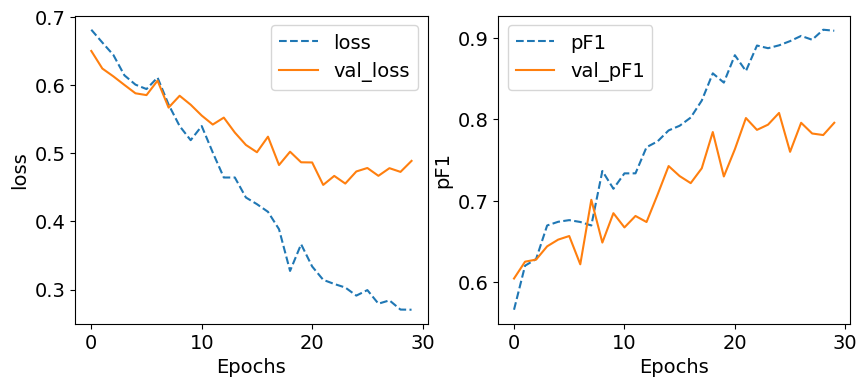

In [44]:
training_plot(['loss', 'pF1'], history)

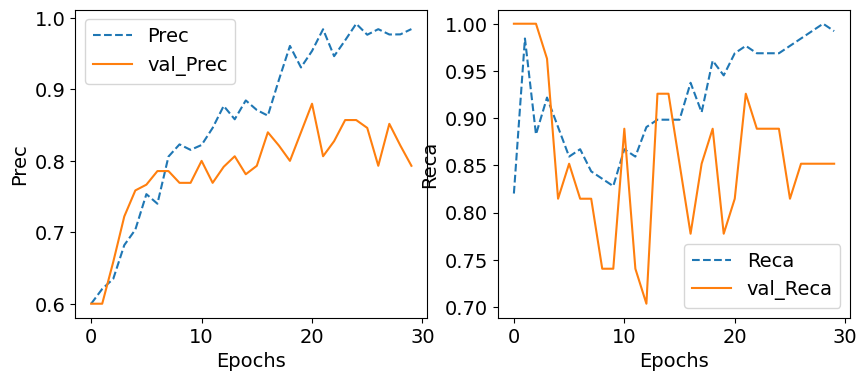

In [45]:
training_plot(['Prec', 'Reca'], history)

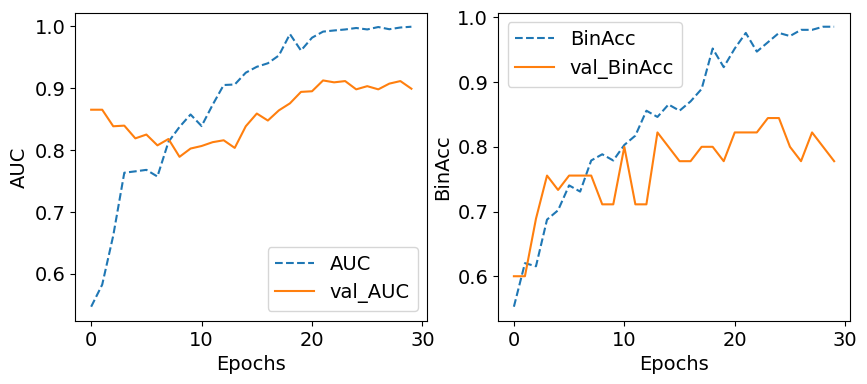

In [46]:
training_plot(['AUC', 'BinAcc'], history)

In [47]:
y_pred_proba = model.predict(test_dataset)

2/2 [==============================] - 2s 628ms/step


In [49]:
labels_test = pd.read_csv("test.csv", names=["File_path", "Label"])
labels_test.head()

,File_path,Label
0,brain_tumor_dataset/yes/Y75.JPG,1
1,brain_tumor_dataset/yes/Y186.jpg,1
2,brain_tumor_dataset/yes/Y192.JPG,1
3,brain_tumor_dataset/yes/Y92.png,1
4,brain_tumor_dataset/yes/Y111.JPG,1


In [51]:
test_labels = labels_test.loc[:, 'Label']

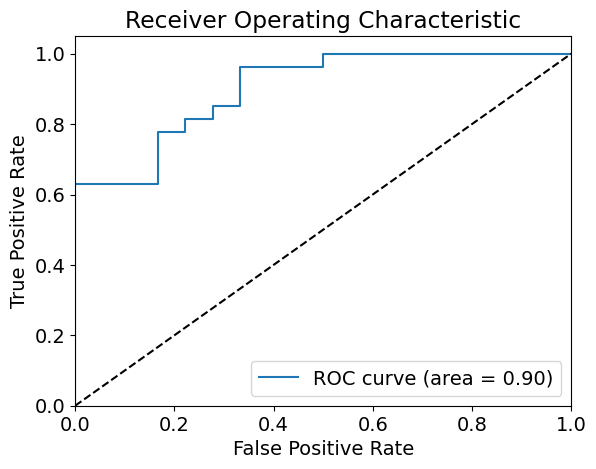

In [55]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [56]:
from sklearn.metrics import confusion_matrix, classification_report

In [58]:
pred_y = (model.predict(test_dataset) > 0.5).astype("int32")
print(classification_report(test_labels, pred_y))

2/2 [==============================] - 2s 635ms/step
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        18
           1       0.79      0.85      0.82        27

    accuracy                           0.78        45
   macro avg       0.77      0.76      0.76        45
weighted avg       0.78      0.78      0.78        45



## Evaluating the model on test dataset

In [3]:
from tensorflow.keras.models import load_model

model = load_model("models/Tumor_dtc_model.h5", compile=False)

In [11]:
CLASS_NAMES = ['0', '1']
IMG_HEIGHT = 256
IMG_WIDTH = 256


def read_and_decode(filename, reshape_dims):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, reshape_dims)

def decode_csv(csv_row):
    record_defaults = ["path", "class"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
    return img, label

def plot_predictions(filename):
    matplotlib.rcParams.update({'font.size': 14})
    f, ax = plt.subplots(3, 5, figsize=(35,15))
    dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
    for idx, (img, label) in enumerate(dataset.take(15)):
        ax[idx//5, idx%5].imshow((img.numpy()));
        batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, 3])
        batch_pred = model.predict(batch_image)
        pred = batch_pred[0]
        label = CLASS_NAMES[label.numpy()]
        pred_label_index = tf.math.argmax(pred).numpy()
        pred_label = CLASS_NAMES[pred_label_index]
        prob = pred[pred_label_index]
        ax[idx//5, idx%5].set_title('{} -> {} ({:.2f})'.format(label, pred_label, prob))
        ax[idx//5, idx%5].axis('off')

1/1 [==============================] - 0s 94ms/step


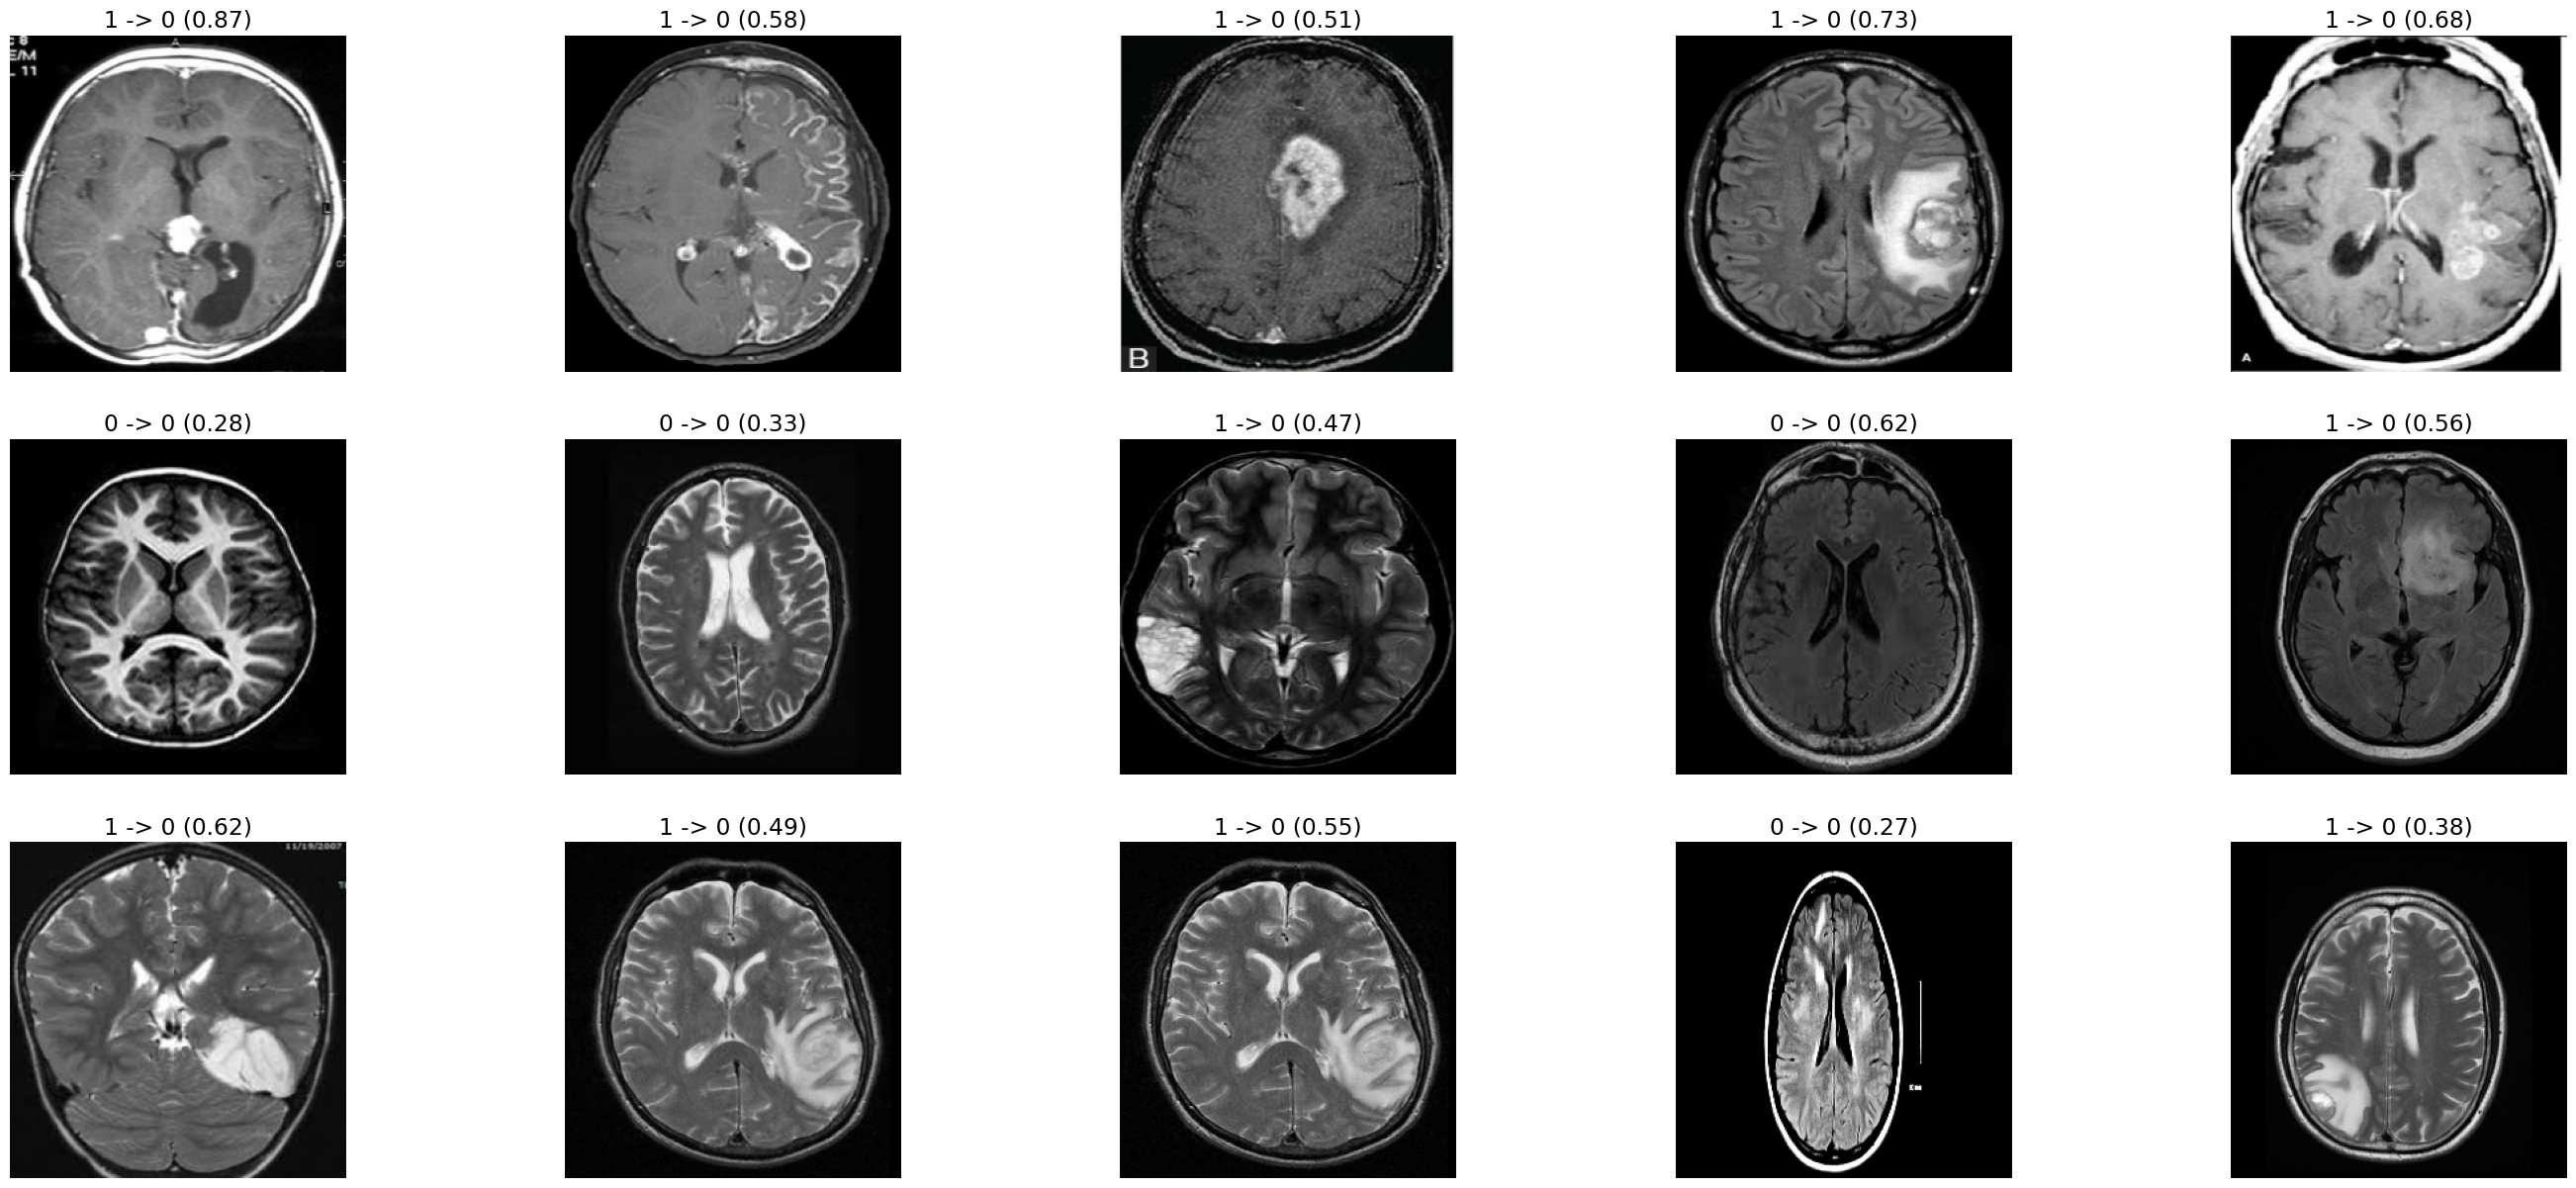

In [12]:
plot_predictions("test.csv")